In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 21/12/2020

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 21/12/2020\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS, \
                                 from_HHMMSS_to_HH                                 
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt, \
                                  compute_start_end_timestamps_from_days_with_regulations
from generator import extract_features_from_list_days_and_timestamps, \
                      extract_days_timestamps_volumes_labels_days_with_regulations

from generator_weather import extract_weather_information_from_list_days_and_timestamps

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, TimeDistributed
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [4]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [5]:
num_epochs = 300
batch_size = 32

In [6]:
num_weather_features = 16
num_metric_per_weather_feature = 3

# Prepare / Extreact data

###  Extract the available regulations

In [7]:
REGULATIONS = read_REGULATIONS_file('./20190604_20191020_REGULATIONS.csv')

"""
If the regulation contains a cancel_time -> It will be ignored
    * To take them into account -> Remove last condition
"""
REGULATIONS = REGULATIONS.loc[(REGULATIONS["regulation_reason"].isin([' W-Weather '])) & 
                              (REGULATIONS["location_type"] == ' En route ') &
                              (REGULATIONS["cancel_time"] == '  ')
                             ] 

In [8]:
# TODO: Try to optimaze the following step (very slow)

# Drop all the regulations which are not associated to a "traffic_volume" == "MAS..."
count_drops = 0
for index, row in REGULATIONS.iterrows():
    
    # The .strip() is requieres because there is a white space at the beginning of the names
    if row["traffic_volume"].strip()[0:3] != 'MAS': 
        REGULATIONS = REGULATIONS.drop(index=index)
        count_drops += 1

In [9]:
print('Number ALL regulations from the given sector: ', str(len(REGULATIONS.values)))

Number ALL regulations from the given sector:  151


In [10]:
# ".strip() -> Remove all the white spaaces in the timestamp"

REGULATIONS.loc[:, 'date_DDMMYYYY'] = REGULATIONS.apply(lambda x: from_YYYYMMDD_to_DDMMYYYY_given_separator(x.target_date.strip(), '/'), axis=1)

REGULATIONS.loc[:, 'start_time_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.start_time.strip()), axis=1)
REGULATIONS.loc[:, 'end_time_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.end_time.strip()), axis=1)
REGULATIONS.loc[:, 'start_time_study_HHMMSS'] = REGULATIONS.apply(lambda x: substract_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_before_start_time), axis=1)
REGULATIONS.loc[:, 'end_time_study_HHMMSS'] = REGULATIONS.apply(lambda x: add_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_after_start_time), axis=1)

In [11]:
# We want to remove from the DataFrame all the rows outside the valid interval of days
# Outside the date of the available AIRACS
min_date = date(2019, 6, 4)
# max_date = date(2019, 8, 14) 
max_date = date(2019, 9, 11) 


for index, row in REGULATIONS.iterrows():
        
    date_split = row["date_DDMMYYYY"].split("/") # 0 -> day; 1 -> month; 2 -> year
    date_object = date(int(date_split[2]), int(date_split[1]), int(date_split[0]))
    
    # Check if the regulation's date belong to the valid interval -> IF outside, drop the Regulation
    if date_object < min_date or date_object > max_date:
        REGULATIONS = REGULATIONS.drop(index=index)

In [12]:
print('Number regulations AFTER pre-processing: ', str(len(REGULATIONS.values)))

Number regulations AFTER pre-processing:  139


In [19]:
# Count all the available regulations per TV
instances_count = dict()
for volume in REGULATIONS['traffic_volume'].values:
    if volume in instances_count.keys():
        instances_count[volume] += 1
    else:
        instances_count[volume] = 1

### Extract the different list of days and timestamps

##### Samples without regulations from days without regulations

In [13]:
# Extract the days with regulations
list_days_with_regulations = REGULATIONS["date_DDMMYYYY"].values

# Initialize a list with all the possible days and the final list for the days without regulations
list_all_possible_days = listDays_betweenTwoDates(min_date, max_date, 'DDMMYYYY', '/')
list_days_without_regulations = list()

In [14]:
# If a day does not appear in the list with reguilations -> No regulations for that day
for day in list_all_possible_days:
    if day not in list_days_with_regulations:
        list_days_without_regulations.append(day)

In [15]:
# For the days without regulations, we will generate random timestamps

list_days_without_regulations_extended = list()
start_time_samples_no_regulations = list()
end_time_samples_no_regulations = list()
list_volumes_no_regulations = list()

for day in list_days_without_regulations:
    # Iterate multiple time each day without regulations
    for _ in range(0,1):
        # Randomly create the hour and the minutes
        hour = str("{:02d}".format(random.randint(3,21))) # From 2 to 22 to avoid extrems (wrap around timestamps)
        minute = str("{:02d}".format(random.randint(0,59)))

        # Create the timestamp
        random_timestamps = hour + ":" + minute + ":" + '00'

        # Substract a given about to create the starting timestamp
        start_timestamp = substract_minutes_given_HHSSMM(random_timestamps, gap_before_start_time)
        start_time_samples_no_regulations.append(start_timestamp)

        # Add a given about to create the ending timestamp
        end_timestamp = add_minutes_given_HHSSMM(random_timestamps, gap_after_start_time)
        end_time_samples_no_regulations.append(end_timestamp)

        # Due to no regulations were createcd for the given day, randomly select a volume
        index_random_volume = random.randint(0, REGULATIONS["traffic_volume"].values.shape[0]-1)
        random_volume = REGULATIONS.iloc[index_random_volume]["traffic_volume"][4:8] # To only save the suffix

        # Some "traffic_volumes" in the REGULATIONS file has different names than the "locations".
        # To avoid this error, we will manually parse this cases
        if random_volume == 'BALB':
            random_volume = 'BLUX'
    
        list_days_without_regulations_extended.append(day)
        list_volumes_no_regulations.append(random_volume)

In [16]:
len(list_days_without_regulations_extended), len(start_time_samples_no_regulations), \
len(end_time_samples_no_regulations), len(list_volumes_no_regulations)

(71, 71, 71, 71)

##### Sample with & without regulations from days with regulations completly random 
##### It is possible ta have sample with both categories (e.g. start NO Regs from Regs and then Reg)

In [17]:
REGULATIONS.loc[:, 'start_regulations_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.start_time.strip()), axis=1)
REGULATIONS.loc[:, 'end_regulations_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.end_time.strip()), axis=1)

In [18]:
list_dates_with_regulations = REGULATIONS["date_DDMMYYYY"].values

start_regulations = REGULATIONS["start_regulations_HHMMSS"].values
end_regulations = REGULATIONS["end_regulations_HHMMSS"].values

list_volumes_regulations = REGULATIONS["traffic_volume"].values

In [25]:
list_dates_with_regulations

array(['04/06/2019', '04/06/2019', '04/06/2019', '04/06/2019',
       '04/06/2019', '04/06/2019', '05/06/2019', '05/06/2019',
       '05/06/2019', '05/06/2019', '05/06/2019', '06/06/2019',
       '07/06/2019', '07/06/2019', '10/06/2019', '11/06/2019',
       '12/06/2019', '12/06/2019', '12/06/2019', '12/06/2019',
       '12/06/2019', '12/06/2019', '13/06/2019', '13/06/2019',
       '13/06/2019', '13/06/2019', '13/06/2019', '14/06/2019',
       '14/06/2019', '15/06/2019', '15/06/2019', '19/06/2019',
       '19/06/2019', '19/06/2019', '19/06/2019', '19/06/2019',
       '19/06/2019', '19/06/2019', '19/06/2019', '19/06/2019',
       '19/06/2019', '19/06/2019', '19/06/2019', '19/06/2019',
       '19/06/2019', '19/06/2019', '19/06/2019', '19/06/2019',
       '19/06/2019', '19/06/2019', '19/06/2019', '19/06/2019',
       '19/06/2019', '19/06/2019', '19/06/2019', '19/06/2019',
       '19/06/2019', '19/06/2019', '19/06/2019', '20/06/2019',
       '20/06/2019', '20/06/2019', '30/06/2019', '01/07

In [26]:
start_regulations

array([150000, 150000, 163000, 173000, 190000, 192000, 150000, 180000,
       180000, 183000, 210000, 150000, 160000, 160000, 170000, 185000,
       113000, 115000, 141500, 154500, 154500, 164000, 161000, 161000,
       162000, 170000, 180000,  70000, 120000,  40000,  74000,  83000,
        83000,  83000,  83000,  83000,  83000,  84000, 113000, 124000,
       133000, 133000, 140000, 140000, 140000, 140000, 140000, 143000,
       143000, 150000, 150000, 170000, 173000, 190000, 190000, 200000,
       200000, 203000, 203000,  80000,  80000, 170000, 184000,  50000,
       110000, 110000, 120000, 133000, 133000, 133000, 140000, 195000,
       123000,  60000,  90000,  90000, 110000, 120000, 120000, 124000,
       130000, 150000, 163000,  53000, 183000, 160000, 170000, 170000,
       171500, 184000,  52000,  72000, 140000, 144500,  82000,  84000,
        91000, 100000, 130000, 143000, 143000, 143000, 143000, 170000,
       140000, 133000, 164000,  90000, 122000, 122000, 132000, 132000,
      

In [27]:
end_regulations

array([220000, 210000, 184000, 221500, 204000, 210000, 173000, 203000,
       210000, 210000, 230000, 174000, 174000, 174000, 200000, 203000,
       140000, 143000, 173000, 191000, 191000, 203000, 180000, 180000,
       200000, 200000, 194000, 100000, 153000,  94000, 100000, 120000,
       132000, 120000, 130000, 113000, 113000, 190000, 123000, 200000,
       190000, 203000, 160000, 203000, 190000, 200000, 200000, 220000,
       173000, 173000, 203000, 203000, 220000, 200000, 205000, 220000,
       220000, 220000, 220000, 100000, 100000, 190000, 203000,  80000,
       134500, 134500, 200000, 161500, 160000, 160000, 174000, 205000,
       150000,  80000, 110000, 163000, 153000, 180000, 180000, 183000,
       183000, 173000, 180000,  73000, 202000, 200000, 190000, 200000,
       184000, 200000,  90000, 120000, 160000, 170000,  91000, 120000,
       140000, 130000, 170000, 180000, 193000, 170000, 193000, 213000,
       170000, 163000, 190000, 183000, 160000, 160000, 160000, 154000,
      

In [28]:
list_volumes_regulations

array([' MASD3WLC ', ' MASD6WH ', ' MASB5KL ', ' MASB3EH ', ' MASDJEV ',
       ' MASB3LL ', ' MASHCEL ', ' MASB3LL ', ' MASB3EH ', ' MASB5WL ',
       ' MASBEST ', ' MASDHOL ', ' MASHMNS ', ' MASHRHR ', ' MASHSOL ',
       ' MASHSOL ', ' MASHRHR ', ' MASD3WLC ', ' MASD3WM ', ' MASHCEL ',
       ' MASHSOL ', ' MASDHOL ', ' MASB3LH ', ' MASB3LL ', ' MASHSOL ',
       ' MASHCEL ', ' MASB5WL ', ' MASDJEV ', ' MASB3EH ', ' MASDHOL ',
       ' MASHRHR ', ' MASD3WM ', ' MASB3EH ', ' MASB3OL ', ' MASB3LL ',
       ' MASH5ML ', ' MASH5RL ', ' MASDJEV ', ' MASHRHR ', ' MASDHOL ',
       ' MASB5NL ', ' MASB5WH ', ' MASHRHR ', ' MASB3EH ', ' MASB5KL ',
       ' MASHSOL ', ' MASHCEL ', ' MASD6WH ', ' MASD3WM ', ' MASD3WL ',
       ' MASB3LL ', ' MASHRHR ', ' MASD3WLC ', ' MASD5JL ', ' MASB5WL ',
       ' MASHEST ', ' MASDEST ', ' MASBOLN ', ' MASBWST ', ' MASD3WM ',
       ' MASD3WL ', ' MASHSOL ', ' MASB3LL ', ' MASB3EH ', ' MASHRHR ',
       ' MASHMNS ', ' MASHSOL ', ' MASH5RL ', ' MASH5ML ', ' 

In [19]:
list_days_from_regulations, \
start_time_samples_days_from_regulations, \
end_time_samples_days_from_regulations, \
volumes_days_from_regulations, \
labels_days_from_regulations = extract_days_timestamps_volumes_labels_days_with_regulations(list_dates_with_regulations, 
                                                                      start_regulations,
                                                                      end_regulations,
                                                                      list_volumes_regulations, 
                                                                      gap_before_start_time, 
                                                                      gap_after_start_time, 
                                                                      num_additional_samples_per_day=20,
                                                                      min_timestamps_with_regulations=10)

In [20]:
len(list_days_from_regulations), len(start_time_samples_days_from_regulations), \
len(end_time_samples_days_from_regulations), len(volumes_days_from_regulations)

(901, 901, 901, 901)

### Extract all the features for the given dates and timestamps

In [21]:
list_days_without_regulations_extended = np.array(list_days_without_regulations_extended)
start_time_samples_no_regulations = np.array(start_time_samples_no_regulations)
end_time_samples_no_regulations = np.array(end_time_samples_no_regulations)
list_volumes_no_regulations = np.array(list_volumes_no_regulations)

In [22]:
X_days_without_regulations = np.zeros((len(list_days_without_regulations_extended), 
                                       int(gap_before_start_time+gap_after_start_time), 
                                       11))
X_days_without_regulations.shape

(71, 30, 11)

In [23]:
X_days_without_regulations = extract_features_from_list_days_and_timestamps(list_days_without_regulations_extended, 
                                                                           start_time_samples_no_regulations, 
                                                                           end_time_samples_no_regulations,
                                                                           list_volumes_no_regulations,
                                                                           gap_before_start_time, gap_after_start_time,
                                                                           X_days_without_regulations)

B3LL | counter: 1
HWST | counter: 2
HSOL | counter: 3
B5WL | counter: 4
B3EH | counter: 5
B3LL | counter: 6
HSOL | counter: 7
BOLN | counter: 8
B3LL | counter: 9
DHOL | counter: 10
B3LL | counter: 11
H5RL | counter: 12
HRHR | counter: 13
HCEL | counter: 14
D3WM | counter: 15
HRHR | counter: 16
D3WL | counter: 17
DEST | counter: 18
DHOL | counter: 19
DHOL | counter: 20
B3EH | counter: 21
B3LL | counter: 22
B5KL | counter: 23
D3WL | counter: 24
D3WM | counter: 25
B3EH | counter: 26
D3WL | counter: 27
HRHR | counter: 28
HCEL | counter: 29
DHOL | counter: 30
B5KL | counter: 31
DHOL | counter: 32
B3LL | counter: 33
HRHR | counter: 34
DJEV | counter: 35
HCEL | counter: 36
B5KL | counter: 37
HMNS | counter: 38
DHOL | counter: 39
HEST | counter: 40
B3EH | counter: 41
HMNS | counter: 42
HCEL | counter: 43
HWST | counter: 44
HSOL | counter: 45
HSOL | counter: 46
HRHR | counter: 47
DHOL | counter: 48
D3WM | counter: 49
D3WL | counter: 50
H5RL | counter: 51
DJEV | counter: 52
D3WL | counter: 53
B3

In [24]:
np.save('./Counting_variables/Weather/X_days_without_regulations', X_days_without_regulations)

In [25]:
list_days_from_regulations = np.array(list_days_from_regulations)
start_time_samples_days_from_regulations = np.array(start_time_samples_days_from_regulations)
end_time_samples_days_from_regulations = np.array(end_time_samples_days_from_regulations)
volumes_days_from_regulations = np.array(volumes_days_from_regulations)

In [26]:
# Avoid a non existeing name of TV in our data
for i in range(len(volumes_days_from_regulations)):
    if volumes_days_from_regulations[i] == 'BALB':
        volumes_days_from_regulations[i] = 'BLUX'

In [27]:
X_days_from_regulations = np.zeros((len(list_days_from_regulations), int(gap_before_start_time+gap_after_start_time), 11))
X_days_from_regulations.shape

(901, 30, 11)

In [28]:
X_days_from_regulations = extract_features_from_list_days_and_timestamps(list_days_from_regulations, 
                                                                       start_time_samples_days_from_regulations, 
                                                                       end_time_samples_days_from_regulations,
                                                                       volumes_days_from_regulations,
                                                                       gap_before_start_time, gap_after_start_time,
                                                                       X_days_from_regulations)

D3WLC | counter: 1
D3WLC | counter: 2
D3WLC | counter: 3
D3WLC | counter: 4
D3WLC | counter: 5
D3WLC | counter: 6
D3WLC | counter: 7
D3WLC | counter: 8
D6WH | counter: 9
D6WH | counter: 10
D6WH | counter: 11
D6WH | counter: 12
D6WH | counter: 13
D6WH | counter: 14
D6WH | counter: 15
D6WH | counter: 16
D6WH | counter: 17
D6WH | counter: 18
B5KL | counter: 19
B5KL | counter: 20
B5KL | counter: 21
B3EH | counter: 22
B3EH | counter: 23
B3EH | counter: 24
B3EH | counter: 25
B3EH | counter: 26
B3EH | counter: 27
B3EH | counter: 28
B3EH | counter: 29
DJEV | counter: 30
DJEV | counter: 31
DJEV | counter: 32
B3LL | counter: 33
B3LL | counter: 34
B3LL | counter: 35
B3LL | counter: 36
B3LL | counter: 37
HCEL | counter: 38
HCEL | counter: 39
B3LL | counter: 40
B3LL | counter: 41
B3LL | counter: 42
B3LL | counter: 43
B3LL | counter: 44
B3LL | counter: 45
B3LL | counter: 46
B3LL | counter: 47
B3EH | counter: 48
B3EH | counter: 49
B3EH | counter: 50
B3EH | counter: 51
B3EH | counter: 52
B3EH | counte

B3LL | counter: 415
B3LL | counter: 416
B3LL | counter: 417
B3EH | counter: 418
B3EH | counter: 419
B3EH | counter: 420
B3EH | counter: 421
B3EH | counter: 422
B3EH | counter: 423
HRHR | counter: 424
HRHR | counter: 425
HRHR | counter: 426
HRHR | counter: 427
HRHR | counter: 428
HMNS | counter: 429
HMNS | counter: 430
HMNS | counter: 431
HMNS | counter: 432
HMNS | counter: 433
HSOL | counter: 434
HSOL | counter: 435
HSOL | counter: 436
HSOL | counter: 437
HSOL | counter: 438
HSOL | counter: 439
HSOL | counter: 440
HSOL | counter: 441
HSOL | counter: 442
H5RL | counter: 443
H5RL | counter: 444
H5RL | counter: 445
H5RL | counter: 446
H5ML | counter: 447
H5ML | counter: 448
H5ML | counter: 449
H5ML | counter: 450
H5WH | counter: 451
H5WH | counter: 452
H5WH | counter: 453
H5WH | counter: 454
H5WH | counter: 455
H5WH | counter: 456
DJEV | counter: 457
DJEV | counter: 458
DJEV | counter: 459
DJEV | counter: 460
DJEV | counter: 461
DJEV | counter: 462
DJEV | counter: 463
DJEV | counter: 464


HRHR | counter: 824
DJEV | counter: 825
DJEV | counter: 826
DJEV | counter: 827
DJEV | counter: 828
DJEV | counter: 829
DJEV | counter: 830
DJEV | counter: 831
DJEV | counter: 832
HMNS | counter: 833
HMNS | counter: 834
HMNS | counter: 835
HMNS | counter: 836
BOLN | counter: 837
BOLN | counter: 838
BOLN | counter: 839
BOLN | counter: 840
BOLN | counter: 841
BOLN | counter: 842
BOLN | counter: 843
BLUX | counter: 844
BLUX | counter: 845
BLUX | counter: 846
BLUX | counter: 847
BLUX | counter: 848
B3LL | counter: 849
B3LL | counter: 850
B3LL | counter: 851
B3LL | counter: 852
B3LL | counter: 853
B3LL | counter: 854
B3LL | counter: 855
B3LL | counter: 856
B3LL | counter: 857
B3LH | counter: 858
B3LH | counter: 859
B3LH | counter: 860
B3LH | counter: 861
B3LH | counter: 862
B3LH | counter: 863
B3LH | counter: 864
B3LH | counter: 865
B3LH | counter: 866
BOLN | counter: 867
BOLN | counter: 868
BOLN | counter: 869
BOLN | counter: 870
BOLN | counter: 871
BOLN | counter: 872
D3WLC | counter: 873

In [29]:
np.save('./Counting_variables/Weather/X_days_from_regulations', X_days_from_regulations)
np.save('./Counting_variables/Weather/labels_days_from_regulations', labels_days_from_regulations)

# Extract the weather features 

In [30]:
X_days_without_regulations_weather = np.zeros((len(list_days_without_regulations_extended), 
                                               int(gap_before_start_time+gap_after_start_time), 
                                               num_weather_features*num_metric_per_weather_feature))
X_days_without_regulations_weather.shape

(71, 30, 48)

In [31]:
X_days_without_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_without_regulations_extended, 
    start_time_samples_no_regulations, 
    end_time_samples_no_regulations,
    list_volumes_no_regulations,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_without_regulations_weather)

day: 08/06/2019 | start:130900 | TV: B3LL
day: 09/06/2019 | start:040400 | TV: HWST
day: 16/06/2019 | start:062300 | TV: HSOL
day: 17/06/2019 | start:191300 | TV: B5WL
day: 18/06/2019 | start:052700 | TV: B3EH
day: 21/06/2019 | start:051500 | TV: B3LL
day: 22/06/2019 | start:202700 | TV: HSOL
day: 23/06/2019 | start:210700 | TV: BOLN
day: 24/06/2019 | start:210300 | TV: B3LL
day: 25/06/2019 | start:041400 | TV: DHOL
day: 26/06/2019 | start:205400 | TV: B3LL
day: 27/06/2019 | start:122600 | TV: H5RL
day: 28/06/2019 | start:200700 | TV: HRHR
day: 29/06/2019 | start:205200 | TV: HCEL
day: 02/07/2019 | start:063700 | TV: D3WM
day: 03/07/2019 | start:140600 | TV: HRHR
day: 04/07/2019 | start:210300 | TV: D3WL
day: 05/07/2019 | start:184300 | TV: DEST
day: 06/07/2019 | start:164900 | TV: DHOL
day: 07/07/2019 | start:173700 | TV: DHOL
day: 08/07/2019 | start:141900 | TV: B3EH
day: 09/07/2019 | start:084400 | TV: B3LL
day: 10/07/2019 | start:053600 | TV: B5KL
day: 11/07/2019 | start:193100 | T

In [32]:
np.save('./Counting_variables/Weather/X_days_without_regulations_weather', X_days_without_regulations_weather)

In [33]:
X_days_from_regulations_weather = np.zeros((len(list_days_from_regulations), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_from_regulations_weather.shape

(901, 30, 48)

In [34]:
X_days_from_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_from_regulations, 
    start_time_samples_days_from_regulations, 
    end_time_samples_days_from_regulations,
    volumes_days_from_regulations,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_from_regulations_weather)

day: 04/06/2019 | start:191100 | TV: D3WLC
day: 04/06/2019 | start:201100 | TV: D3WLC
day: 04/06/2019 | start:192900 | TV: D3WLC
day: 04/06/2019 | start:204400 | TV: D3WLC
day: 04/06/2019 | start:193100 | TV: D3WLC
day: 04/06/2019 | start:141100 | TV: D3WLC
day: 04/06/2019 | start:182200 | TV: D3WLC
day: 04/06/2019 | start:034000 | TV: D3WLC
day: 04/06/2019 | start:094000 | TV: D6WH
day: 04/06/2019 | start:165000 | TV: D6WH
day: 04/06/2019 | start:153900 | TV: D6WH
day: 04/06/2019 | start:151500 | TV: D6WH
day: 04/06/2019 | start:082000 | TV: D6WH
day: 04/06/2019 | start:171900 | TV: D6WH
day: 04/06/2019 | start:183200 | TV: D6WH
day: 04/06/2019 | start:073700 | TV: D6WH
day: 04/06/2019 | start:161800 | TV: D6WH
day: 04/06/2019 | start:043200 | TV: D6WH
day: 04/06/2019 | start:172100 | TV: B5KL
day: 04/06/2019 | start:184200 | TV: B5KL
day: 04/06/2019 | start:192600 | TV: B5KL
day: 04/06/2019 | start:063500 | TV: B3EH
day: 04/06/2019 | start:203900 | TV: B3EH
day: 04/06/2019 | start:17

day: 19/06/2019 | start:113600 | TV: B3LL
day: 19/06/2019 | start:162500 | TV: B3LL
day: 19/06/2019 | start:123100 | TV: B3LL
day: 19/06/2019 | start:082600 | TV: B3LL
day: 19/06/2019 | start:181600 | TV: B3LL
day: 19/06/2019 | start:133900 | TV: B3LL
day: 19/06/2019 | start:061900 | TV: B3LL
day: 19/06/2019 | start:045000 | TV: B3LL
day: 19/06/2019 | start:094500 | TV: B3LL
day: 19/06/2019 | start:182800 | TV: B3LL
day: 19/06/2019 | start:112500 | TV: B3LL
day: 19/06/2019 | start:101600 | TV: B3LL
day: 19/06/2019 | start:152800 | TV: B3LL
day: 19/06/2019 | start:162000 | TV: B3LL
day: 19/06/2019 | start:081800 | TV: H5ML
day: 19/06/2019 | start:084300 | TV: H5ML
day: 19/06/2019 | start:102100 | TV: H5ML
day: 19/06/2019 | start:094800 | TV: H5ML
day: 19/06/2019 | start:051500 | TV: H5ML
day: 19/06/2019 | start:094700 | TV: H5ML
day: 19/06/2019 | start:181800 | TV: H5ML
day: 19/06/2019 | start:084600 | TV: H5RL
day: 19/06/2019 | start:042800 | TV: H5RL
day: 19/06/2019 | start:101500 | T

day: 19/06/2019 | start:084000 | TV: BOLN
day: 19/06/2019 | start:061900 | TV: BWST
day: 19/06/2019 | start:031800 | TV: BWST
day: 19/06/2019 | start:153100 | TV: BWST
day: 19/06/2019 | start:131400 | TV: BWST
day: 19/06/2019 | start:064100 | TV: BWST
day: 19/06/2019 | start:204200 | TV: BWST
day: 20/06/2019 | start:092400 | TV: D3WM
day: 20/06/2019 | start:164500 | TV: D3WM
day: 20/06/2019 | start:133900 | TV: D3WL
day: 20/06/2019 | start:202400 | TV: D3WL
day: 20/06/2019 | start:112600 | TV: D3WL
day: 20/06/2019 | start:071400 | TV: D3WL
day: 20/06/2019 | start:171500 | TV: HSOL
day: 20/06/2019 | start:171700 | TV: HSOL
day: 20/06/2019 | start:175000 | TV: HSOL
day: 20/06/2019 | start:182100 | TV: HSOL
day: 20/06/2019 | start:171500 | TV: HSOL
day: 20/06/2019 | start:042800 | TV: HSOL
day: 20/06/2019 | start:164800 | TV: HSOL
day: 30/06/2019 | start:211800 | TV: B3LL
day: 30/06/2019 | start:093100 | TV: B3LL
day: 30/06/2019 | start:193600 | TV: B3LL
day: 30/06/2019 | start:182100 | T

day: 27/07/2019 | start:041000 | TV: D6WH
day: 27/07/2019 | start:132700 | TV: D6WH
day: 27/07/2019 | start:101000 | TV: D6WH
day: 27/07/2019 | start:083000 | TV: BOLN
day: 27/07/2019 | start:074400 | TV: BOLN
day: 27/07/2019 | start:044500 | TV: BOLN
day: 27/07/2019 | start:093100 | TV: BOLN
day: 27/07/2019 | start:063000 | TV: BOLN
day: 27/07/2019 | start:093900 | TV: BOLN
day: 27/07/2019 | start:144600 | TV: BOLN
day: 02/08/2019 | start:203300 | TV: D3WM
day: 02/08/2019 | start:073700 | TV: D3WM
day: 02/08/2019 | start:074800 | TV: D3WM
day: 02/08/2019 | start:201700 | TV: D3WM
day: 02/08/2019 | start:141300 | TV: D3WM
day: 02/08/2019 | start:162300 | TV: H5RL
day: 02/08/2019 | start:164200 | TV: H5RL
day: 02/08/2019 | start:044100 | TV: H5RL
day: 02/08/2019 | start:171500 | TV: H5RL
day: 02/08/2019 | start:163200 | TV: H5RL
day: 09/08/2019 | start:143400 | TV: D3WLC
day: 09/08/2019 | start:084500 | TV: D3WLC
day: 09/08/2019 | start:084500 | TV: B5WL
day: 09/08/2019 | start:144300 |

day: 28/08/2019 | start:164900 | TV: DHOL
day: 28/08/2019 | start:151600 | TV: DHOL
day: 28/08/2019 | start:181600 | TV: DHOL
day: 28/08/2019 | start:151600 | TV: DHOL
day: 28/08/2019 | start:183700 | TV: DHOL
day: 28/08/2019 | start:194800 | TV: DHOL
day: 28/08/2019 | start:182900 | TV: DHOL
day: 28/08/2019 | start:044800 | TV: DHOL
day: 28/08/2019 | start:151600 | TV: DHOL
day: 28/08/2019 | start:125000 | TV: D6WH
day: 28/08/2019 | start:042800 | TV: D6WH
day: 28/08/2019 | start:152400 | TV: D6WH
day: 28/08/2019 | start:211900 | TV: D6WH
day: 28/08/2019 | start:153200 | TV: D6WH
day: 28/08/2019 | start:202800 | TV: D6WH
day: 28/08/2019 | start:181300 | TV: D6WH
day: 28/08/2019 | start:211700 | TV: D6WH
day: 28/08/2019 | start:174200 | TV: B5WL
day: 28/08/2019 | start:062300 | TV: B5WL
day: 28/08/2019 | start:031300 | TV: B5WL
day: 28/08/2019 | start:111600 | TV: B5WL
day: 28/08/2019 | start:131800 | TV: B5WL
day: 28/08/2019 | start:074900 | TV: B5WL
day: 28/08/2019 | start:062800 | T

In [35]:
np.save('./Counting_variables/Weather/X_days_from_regulations_weather', X_days_from_regulations_weather)

# Concatenate the scalar variables and the weather features

In [14]:
X_days_without_regulations = np.load('./Counting_variables/Weather/X_days_without_regulations.npy')
X_days_without_regulations_weather = np.load('./Counting_variables/Weather/X_days_without_regulations_weather.npy')

X_days_from_regulations = np.load('./Counting_variables/Weather/X_days_from_regulations.npy')
X_days_from_regulations_weather = np.load('./Counting_variables/Weather/X_days_from_regulations_weather.npy')

labels_days_from_regulations = np.load('./Counting_variables/Weather/labels_days_from_regulations.npy')

In [15]:
X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
                                                   X_days_without_regulations.shape[1],
                                                   X_days_without_regulations.shape[2]+X_days_without_regulations_weather.shape[2]))

X_days_without_regulations_concatenate.shape

(29, 30, 59)

In [16]:
X_days_without_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_without_regulations_weather
X_days_without_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_without_regulations

In [17]:
# np.save('./Counting_variables/Weather/X_days_without_regulations_concatenate', X_days_without_regulations_concatenate)

In [18]:
X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
                                                X_days_from_regulations.shape[1],
                                                X_days_from_regulations.shape[2]+X_days_from_regulations_weather.shape[2]))

X_days_from_regulations_concatenate.shape

(967, 30, 59)

In [19]:
X_days_from_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_from_regulations_weather
X_days_from_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_from_regulations

In [20]:
# np.save('./Counting_variables/Weather/X_days_from_regulations_concatenate', X_days_from_regulations_concatenate)

# Create the labels

In [21]:
Y_days_without_regulations = np.zeros((X_days_without_regulations_concatenate.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [22]:
Y_days_without_regulations.shape

(29, 30, 1)

In [23]:
Y_from_regulations = np.zeros((X_days_from_regulations_concatenate.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [24]:
Y_from_regulations = labels_days_from_regulations

In [25]:
Y_from_regulations.shape

(967, 30, 1)

# Split into training & testing - By day

In [26]:
num_train_samples_days_without_regulations = int(np.floor(X_days_without_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_without_regulations

20

In [27]:
num_train_samples_days_from_regulations = int(np.floor(X_days_from_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_from_regulations

676

In [28]:
X_train = np.concatenate((X_days_without_regulations_concatenate[0:num_train_samples_days_without_regulations],
                          X_days_from_regulations_concatenate[0:num_train_samples_days_from_regulations]))

y_train = np.concatenate((Y_days_without_regulations[0:num_train_samples_days_without_regulations],
                          Y_from_regulations[0:num_train_samples_days_from_regulations]))

In [29]:
X_train.shape, y_train.shape

((696, 30, 59), (696, 30, 1))

In [30]:
X_test = np.concatenate((X_days_without_regulations_concatenate[num_train_samples_days_without_regulations:],
                         X_days_from_regulations_concatenate[num_train_samples_days_from_regulations:]))

y_test = np.concatenate((Y_days_without_regulations[num_train_samples_days_without_regulations:],
                         Y_from_regulations[num_train_samples_days_from_regulations:]))

In [31]:
X_test.shape, y_test.shape

((300, 30, 59), (300, 30, 1))

In [32]:
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/X_train', X_train)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/y_train', y_train)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/X_test', X_test)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/y_test', y_test)

# Only using the max values form the weather features

In [33]:
X_train.shape, X_test.shape

((696, 30, 59), (300, 30, 59))

In [34]:
list_weather_features_delete = []
for i in range(num_weather_features):
    list_weather_features_delete.append(0+i*num_metric_per_weather_feature)
    list_weather_features_delete.append(1+i*num_metric_per_weather_feature)
    
# Additional elements added to the delete list
list_weather_features_delete.append(1*3-1)
list_weather_features_delete.append(3*3-1)
# list_weather_features_delete.append(4*3-1)
# list_weather_features_delete.append(11*3-1)
# list_weather_features_delete.append(3*3-1)
# list_weather_features_delete.append(3*3-1)

In [35]:
X_train_del = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2]-len(list_weather_features_delete)))
X_test_del = np.zeros((X_test.shape[0], X_test.shape[1], X_train.shape[2]-len(list_weather_features_delete)))

for j in range(X_train.shape[0]):
    X_train_del[j] = np.delete(X_train[j], list_weather_features_delete, axis=1)
for j in range(X_test.shape[0]):
    X_test_del[j] = np.delete(X_test[j], list_weather_features_delete, axis=1)


In [36]:
X_train_del.shape, X_test_del.shape

((696, 30, 25), (300, 30, 25))

In [37]:
# Used it to avoid having to change the name of the variables in the following lines
X_train = X_train_del
X_test = X_test_del

# Train the model

In [38]:
from keras.layers import BatchNormalization
from keras.models import Sequential

In [152]:
def Hotspoter_v2(input_shape):

    daily_traffic = Input(shape=input_shape)
    
    X = LSTM(X_train.shape[2], return_sequences=True)(daily_traffic)
    X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)

    X = LSTM(X_train.shape[2]*2, return_sequences = True)(X)
    X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
    X = LSTM(X_train.shape[2]*3, return_sequences = True)(X)
    X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
#     X = LSTM(X_train.shape[2]*4, return_sequences = True)(X)
#     X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)

    X = LSTM(X_train.shape[2], return_sequences = True)(X)
    X = Dropout(0.5)(X)
#     X =  BatchNormalization()(X)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
    model = Model(inputs=daily_traffic, outputs=X)

    
    return model

In [153]:
num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

model = Hotspoter_v2((num_timestamps_per_sample, X_train.shape[2]))

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 30, 25)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 30, 25)            5100      
_________________________________________________________________
dropout_20 (Dropout)         (None, 30, 25)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 30, 50)            15200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 30, 75)            37800     
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 75)            0   

In [154]:
# Anopther option: sparse_categorical_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [155]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 200, batch_size = batch_size, shuffle=True)

Train on 696 samples, validate on 300 samples
Epoch 1/200
696/696 [==============================] - 2s 3ms/step - loss: 0.6929 - accuracy: 0.5236 - val_loss: 0.6900 - val_accuracy: 0.5313
Epoch 2/200
696/696 [==============================] - 1s 1ms/step - loss: 0.6669 - accuracy: 0.6089 - val_loss: 0.6874 - val_accuracy: 0.5630
Epoch 3/200
696/696 [==============================] - 1s 1ms/step - loss: 0.6448 - accuracy: 0.6320 - val_loss: 0.6331 - val_accuracy: 0.6441
Epoch 4/200
696/696 [==============================] - 1s 1ms/step - loss: 0.6332 - accuracy: 0.6473 - val_loss: 0.7003 - val_accuracy: 0.5542
Epoch 5/200
696/696 [==============================] - 1s 1ms/step - loss: 0.6273 - accuracy: 0.6608 - val_loss: 0.6335 - val_accuracy: 0.6102
Epoch 6/200
696/696 [==============================] - 1s 1ms/step - loss: 0.6117 - accuracy: 0.6625 - val_loss: 0.6203 - val_accuracy: 0.6722
Epoch 7/200
696/696 [==============================] - 1s 1ms/step - loss: 0.6179 - accuracy: 0.

Epoch 114/200
696/696 [==============================] - 1s 1ms/step - loss: 0.5147 - accuracy: 0.7480 - val_loss: 0.5893 - val_accuracy: 0.7197
Epoch 115/200
696/696 [==============================] - 1s 1ms/step - loss: 0.5154 - accuracy: 0.7406 - val_loss: 0.6640 - val_accuracy: 0.6248
Epoch 116/200
696/696 [==============================] - 1s 1ms/step - loss: 0.5175 - accuracy: 0.7497 - val_loss: 0.5970 - val_accuracy: 0.6818
Epoch 117/200
696/696 [==============================] - 1s 1ms/step - loss: 0.5113 - accuracy: 0.7491 - val_loss: 0.5902 - val_accuracy: 0.6750
Epoch 118/200
696/696 [==============================] - 1s 1ms/step - loss: 0.5117 - accuracy: 0.7443 - val_loss: 0.6295 - val_accuracy: 0.6658
Epoch 119/200
696/696 [==============================] - 1s 1ms/step - loss: 0.5166 - accuracy: 0.7515 - val_loss: 0.6233 - val_accuracy: 0.6427
Epoch 120/200
696/696 [==============================] - 1s 1ms/step - loss: 0.5089 - accuracy: 0.7475 - val_loss: 0.6173 - val_ac

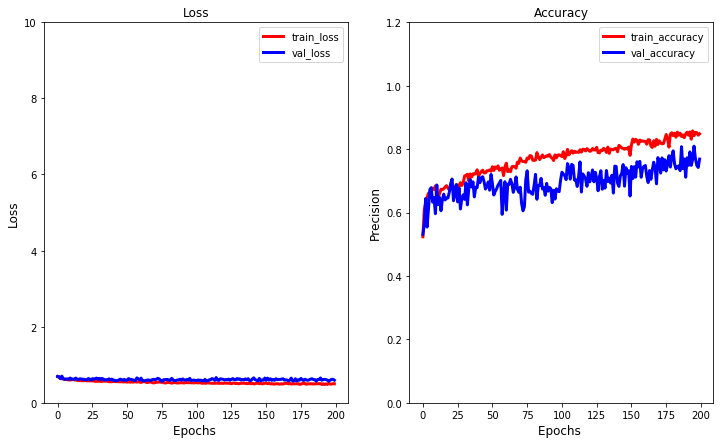

In [269]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [175]:
from metrics import confusion_matrix_sequencialOutput, confusion_matrix_sequencial_output_mean_std

### Training samples

In [272]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_train, y_train, 
                                                                (gap_before_start_time + gap_after_start_time))

In [273]:
conf_matrix

array([[7416., 2408.],
       [2315., 8741.]])

In [274]:
print("Accuracy trainng: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall trainng: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion trainng: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy trainng: 87.38%
Recall trainng: 86.21%
Precicion trainng: 85.49%


### Testing samples

In [276]:
TP, FP, TN, FN, conf_matrix = confusion_matrix_sequencialOutput(model, 
                                                                X_test, y_test, 
                                                                (gap_before_start_time + gap_after_start_time))

In [277]:
conf_matrix

array([[3086., 1330.],
       [1564., 3020.]])

In [278]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 77.84%
Recall testing: 76.37%
Precicion testing: 79.88%


# Analysing similaritis

In [285]:
from metrics import similarity_sequential_output_percentage_correct

In [293]:
equal, similar, incorrect = similarity_sequential_output_percentage_correct(model, X_test, y_test, 80)

In [295]:
equal, similar, incorrect

(0.5266666666666666, 0.3133333333333333, 0.15999999999999998)

# From many-to-many to many-to-one

In [185]:
from metrics import detect_regulations_binary, updated_detect_regulations_binary, updated_detect_regulations_binary_mean_std

In [186]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = detect_regulations_binary(model, X_test, y_test)

In [187]:
conf_matrix_binary

array([[170.,  40.],
       [  0.,  88.]])

In [188]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 86.58%
Recall testing: 100.00%
Precicion testing: 80.95%


In [296]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = updated_detect_regulations_binary(model, 
                                                                                                   X_test, 
                                                                                                   y_test, 10)

In [297]:
conf_matrix_binary

array([[110.,  44.],
       [ 55.,  91.]])

In [299]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 77.00%
Recall testing: 79.67%
Precicion testing: 81.43%


# Saving the model 

In [300]:
model.save('./Counting_variables/Weather/Meeting_20201226')